# Code for "Creating Correct and Capable Classifiers"

* A set of examples for diagnosing "correct and capable classifiers"
* pandas_profiling
* Starting with a baseline model before building 'better' classifiers
* Diagnosing which parts of model-space are easier to predict correctly
* YellowBrick for ROC and Confusion Matrices
* Confusion Matrix probabilities
* T-SNE to group together similar examples
* ELI5 and SHAPley to explain predictions

* Example code connected to two conference talks
  * http://ianozsvald.com/2018/05/26/creating-correct-and-capable-classifiers-at-pydataamsterdam-2018/
  * http://ianozsvald.com/2018/04/30/pydatalondon-2018-and-creating-correct-and-capable-classifiers/
  

In [1]:
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import skopt
from skopt import BayesSearchCV

from yellowbrick import ROCAUC
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from eli5 import explain_weights
from eli5.sklearn import PermutationImportance
import eli5
from lime import lime_tabular # via pip install git+https://github.com/marcotcr/lime.git

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# https://matplotlib.org/users/dflt_style_changes.html
# https://matplotlib.org/users/customizing.html
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'

CV_N_REPEATS = 20
BINS = 10

In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,yellowbrick,statsmodels,patsy,xgboost,pandas -g

2018-05-27 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
matplotlib 2.2.2
sklearn 0.19.1
eli5 0.8
seaborn 0.8.1
yellowbrick 0.6
statsmodels 0.8.0
patsy 0.5.0
xgboost 0.7.post4
pandas 0.22.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.91-040991-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [3]:
# run a couple of patches to fix known bugs
#%run -i patches.py

In [4]:
df = pd.read_csv("titanic_train.csv")
df = df.set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

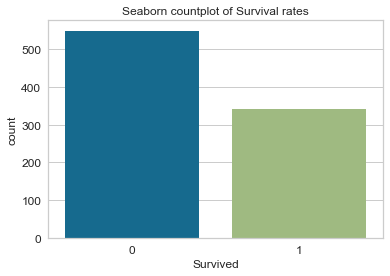

In [8]:
ax = sns.countplot(data=df, x='Survived')
ax.set_title("Seaborn countplot of Survival rates");

In [9]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

# Add some features, create X, y and a train/test split

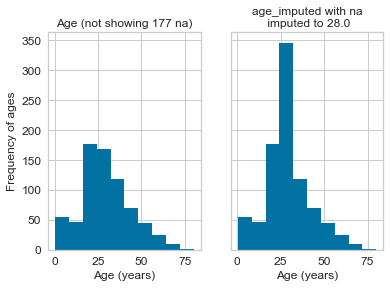

In [10]:
# make some additional features
df['SibSpParch'] = df.SibSp + df.Parch
df['is_female'] = (df.Sex != 'male').astype(np.int_)

df['age_imputed'] = df.Age.copy()
median_age = df.Age.dropna().median()
# note we ought to use a Pipeline here rather than 
# working off of the global median
df['age_imputed'] = df.age_imputed.fillna(median_age)

#print(df.Age.isnull().sum(), df.age_imputed.isnull().sum())
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].set_title("Age (not showing {} na)".format(df.Age.isnull().sum()))
axs[1].set_title("age_imputed with na\n imputed to {}".format(df.Age.dropna().median()))
df.Age.hist(ax=axs[0])
df.age_imputed.hist(ax=axs[1]);
axs[0].set_xlabel("Age (years)")
axs[1].set_xlabel("Age (years)")
axs[0].set_ylabel("Frequency of ages");

In [11]:
# possible different directions we could take with imputation
# note we'd want to use a pipeline to do this properly
df.query('is_female==True').Age.dropna().median(), df.query('is_female==False').Age.dropna().median()

(27.0, 29.0)

In [12]:
# 'Age' has missing data
df_ml = df[['Survived', 'Pclass', 'is_female', 'SibSpParch', 'Fare', 'age_imputed']].copy()

# Make X, y

In [13]:
X = df_ml.drop('Survived', axis=1)
y = df_ml['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train.head()

,Pclass,is_female,SibSpParch,Fare,age_imputed
PassengerId,,,,,
106,3,0,0,7.8958,28.0
69,3,1,6,7.9250,17.0
254,3,0,1,16.1000,30.0
321,3,0,0,7.2500,22.0
707,2,1,0,13.5000,45.0


# Try DummyClassifier

In [14]:
clf_dummy = DummyClassifier(strategy="most_frequent")
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.6322869955156951

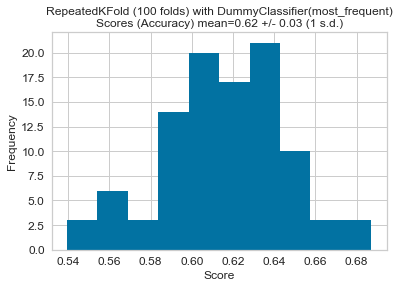

In [15]:
strategy = "most_frequent"
clf_dummy = DummyClassifier(strategy=strategy)
scores = cross_val_score(clf_dummy, 
                         X, y, 
                         cv=RepeatedKFold(n_repeats=CV_N_REPEATS), 
                         scoring=None) 
scores_dummy = scores

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

# Make a classifier

In [16]:
clf = RandomForestClassifier(n_estimators=200, max_depth=7)  # hyperparameters optimised using BayesSearchCV
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### BayesSearchCV

* https://scikit-optimize.github.io/#skopt.BayesSearchCV
* should we use an AUC scorer (not accuracy?)

Note that the following error will be fixed: https://github.com/scikit-learn/scikit-learn/pull/9816
```
label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
```

In [17]:
if False:
    # Set to True if we want to run the BayesSearchCV process
    params = {'n_estimators': (5,400),
              'max_depth': (3, 50)}

    optimiser = BayesSearchCV(clf, params, n_jobs=-1, n_iter=50)
    #opt = BayesSearchCV( SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )
    #executes bayesian optimization

    # note we're fitting on all the data, so we're optimising wrt to the test data (might be silly)
    optimiser.fit(X_train, y_train)

    print(optimiser.score(X_test, y_test), optimiser.best_params_)
    #pd.DataFrame(optimiser.cv_results_)

## Use a good configuration

In [18]:
clf.score(X_test, y_test)

0.8430493273542601

### Check variance in prediction quality

In [19]:
scores = cross_val_score(clf, X, y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), n_jobs=-1)
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Scores mean=0.83 +/- 0.02 (1 s.d.)


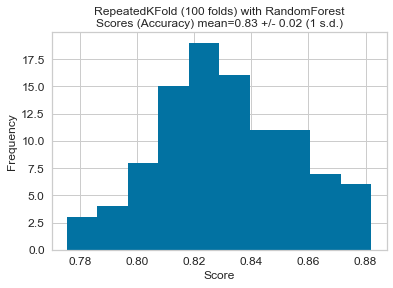

In [20]:
score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

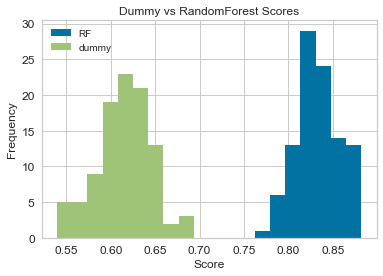

In [21]:
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy': scores_dummy, 'RF': scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel("Score")
ax.set_title("Dummy vs RandomForest Scores");

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8340807174887892

# Feature weights vs Permutation Importance

In [23]:
# https://github.com/TeamHG-Memex/eli5/issues/252
clf_to_explain = clf
try:
    clf.__getattribute__("get_booster")
    clf_to_explain = clf.get_booster()
except AttributeError:
    pass

In [24]:
feature_names = X.columns.values 
explain_weights(clf, feature_names=feature_names)

Weight,Feature
0.3997 ± 0.1630,is_female
0.2120 ± 0.1503,Fare
0.1819 ± 0.0855,age_imputed
0.1147 ± 0.1098,Pclass
0.0916 ± 0.0782,SibSpParch


* https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [25]:
# workaround for bug https://github.com/TeamHG-Memex/eli5/issues/256
X_train_dbg = X_train.as_matrix()
y_train_dbg = y_train.as_matrix()
X_test_dbg = X_test.as_matrix()
y_test_dbg = y_test.as_matrix()
clf.fit(X_train_dbg, y_train_dbg) 
#perm = PermutationImportance(clf).fit(X_test_dbg, y_test_dbg)
perm = PermutationImportance(clf).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2215 ± 0.0586,is_female
0.0933 ± 0.0297,Pclass
0.0422 ± 0.0224,age_imputed
0.0197 ± 0.0166,SibSpParch
0.0188 ± 0.0132,Fare


### Add a confusion matrix

Note that red means "not 100%" and yellow indicates off-axis non-zero results. Docs: http://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

Tiny font issue: https://github.com/DistrictDataLabs/yellowbrick/issues/301

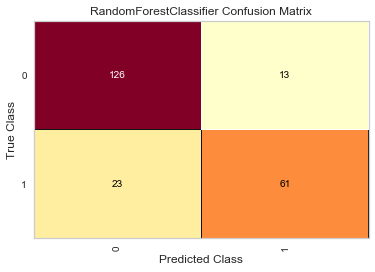

In [26]:
fig, ax = plt.subplots()
cm = ConfusionMatrix(clf, classes=[0, 1], ax=ax)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

#How did we do?
cm.poof()

## Make histograms from the confusion matrix

In [27]:
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)

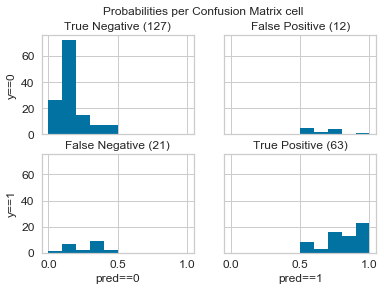

In [28]:
df_predictions = pd.DataFrame({'y': y_test, 'y_proba': y_pred_proba[:,1]})
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# show true-pos 

bins = np.arange(0, 1.01, 0.1)

def show_quarter(df, query, col, title, ax, bins, x_label=None, y_label=None):
    results = df.query(query)
    results[col].hist(ax=ax, bins=bins); 
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
    ax.set_title(title + " ({})".format(results.shape[0])) #IANBOB
show_quarter(df_predictions, "y==0 and y_proba < 0.5", "y_proba", "True Negative", axs[0][0], bins, y_label="y==0")
show_quarter(df_predictions, "y==0 and y_proba >= 0.5", "y_proba", "False Positive", axs[0][1], bins)
show_quarter(df_predictions, "y==1 and y_proba >= 0.5", "y_proba", "True Positive", axs[1][1], bins, x_label="pred==1")
show_quarter(df_predictions, "y==1 and y_proba < 0.5", "y_proba", "False Negative", axs[1][0], bins, x_label="pred==0", y_label="y==1")
fig.suptitle("Probabilities per Confusion Matrix cell");

## Classification report

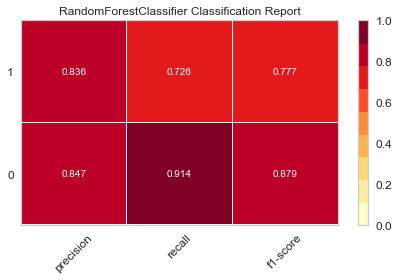

In [29]:
fig, ax = plt.subplots()
visualizer = ClassificationReport(clf, classes=[0, 1], ax=ax)
ax.grid(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

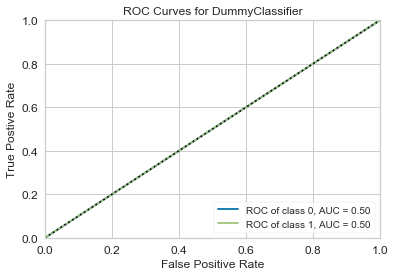

In [30]:
visualizer = ROCAUC(clf_dummy, micro=False, macro=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

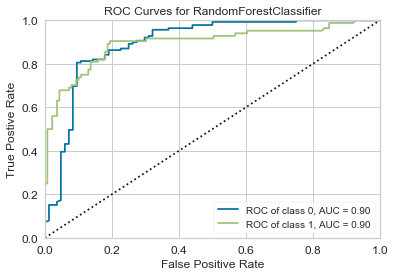

In [31]:
visualizer = ROCAUC(clf, micro=False, macro=False, per_class=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### Create an untuned Logistsicregression classifier for a comparison

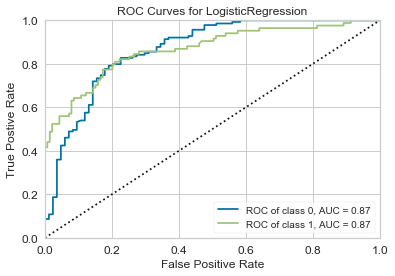

In [32]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
visualizer = ROCAUC(clf_lr, micro=False, macro=False, per_class=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# Identify worsts predictions

In [33]:
proba_y_test_clf = clf.predict_proba(X_test)[:,1]
df_test = pd.DataFrame({'proba': proba_y_test_clf}, index=X_test.index)
df_test['truth'] = y_test.values
df_test['abs_error'] = (df_test.truth - df_test.proba).abs()
df_test.head(5)

,proba,truth,abs_error
PassengerId,,,
496,0.141086,0,0.141086
649,0.095839,0,0.095839
279,0.038517,0,0.038517
32,0.878643,1,0.121357
256,0.538247,1,0.461753


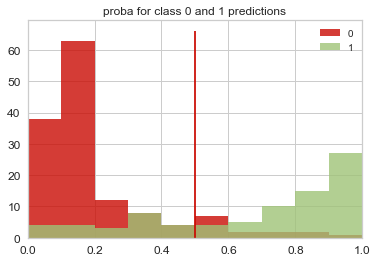

In [34]:
fig, ax = plt.subplots()
bins = np.arange(0, 1.01, 0.1)
df_test.query("truth==0")['proba'].hist(ax=ax, color='r', alpha=0.8, bins=bins, label="0")
df_test.query("truth==1")['proba'].hist(ax=ax, color='g', alpha=0.8, bins=bins, label="1");
ax.legend()
ax.vlines(0.5, 0, ax.get_ylim()[1], color='r')
ax.set_xlim((0, 1.0));
ax.set_title("proba for class 0 and 1 predictions");

In [35]:
# Get worst errors for this class
df_test_worst_errors_by_class = df_test.query('truth==1'). \
                                sort_values(by='abs_error', 
                                ascending=False)
df_test_worst_errors_by_class.head(10)

,proba,truth,abs_error
PassengerId,,,
571,0.059769,1,0.940231
205,0.088605,1,0.911395
763,0.088663,1,0.911337
284,0.090411,1,0.909589
268,0.118401,1,0.881599
648,0.121464,1,0.878536
302,0.131720,1,0.868280
588,0.183245,1,0.816755
56,0.257571,1,0.742429


In [36]:
index_to_debug = df_test_worst_errors_by_class.index[0]
print("Debugging", index_to_debug)
X_test.loc[index_to_debug]

Debugging 571


Pclass          2.0
is_female       0.0
SibSpParch      0.0
Fare           10.5
age_imputed    62.0
Name: 571, dtype: float64

In [37]:
# use iloc to index by integer into X_test
clf.predict_proba([X_test.loc[index_to_debug]]), y_test.loc[index_to_debug]

(array([[0.94023107, 0.05976893]]), 1)

In [38]:
test_features_prediction = pd.concat((X_test, df_test), axis=1)
print(test_features_prediction.loc[index_to_debug])


Pclass          2.000000
is_female       0.000000
SibSpParch      0.000000
Fare           10.500000
age_imputed    62.000000
proba           0.059769
truth           1.000000
abs_error       0.940231
Name: 571, dtype: float64


In [39]:
# given the filter above (for 1 or 0 errors), show the worst offenders
test_features_prediction.loc[df_test_worst_errors_by_class.index].head(10) \
.style \
.background_gradient(cmap='summer', low=2) \
.set_caption('For worsts errors, show the features we use')

,Pclass,is_female,SibSpParch,Fare,age_imputed,proba,truth,abs_error
PassengerId,,,,,,,,
571,2,0,0,10.5,62,0.0597689,1,0.940231
205,3,0,0,8.05,18,0.088605,1,0.911395
763,3,0,0,7.2292,20,0.0886628,1,0.911337
284,3,0,0,8.05,19,0.0904107,1,0.909589
268,3,0,1,7.775,25,0.118401,1,0.881599
648,1,0,0,35.5,56,0.121464,1,0.878536
302,3,0,2,23.25,28,0.13172,1,0.86828
588,1,0,2,79.2,60,0.183245,1,0.816755
56,1,0,0,35.5,28,0.257571,1,0.742429


In [40]:
test_features_prediction.query("Pclass==1 and is_female==False and abs_error > 0.7") \
.style \
.background_gradient(cmap='summer', low=2) \
.set_caption('Focus on 1st class males with worst errors')

,Pclass,is_female,SibSpParch,Fare,age_imputed,proba,truth,abs_error
PassengerId,,,,,,,,
56,1,0,0,35.5,28,0.257571,1,0.742429
588,1,0,2,79.2,60,0.183245,1,0.816755
682,1,0,0,76.7292,27,0.278487,1,0.721513
648,1,0,0,35.5,56,0.121464,1,0.878536


### Show that Pclass==2 is more predictable that Pclass==1

In [41]:
subset_features_predictions = test_features_prediction.query('Pclass==1') 
print("Number of examples:", subset_features_predictions.shape[0])
print(classification_report(subset_features_predictions.truth, 
                            subset_features_predictions.proba>0.5))

Number of examples: 53
             precision    recall  f1-score   support

          0       0.57      0.94      0.71        17
          1       0.96      0.67      0.79        36

avg / total       0.84      0.75      0.76        53



In [42]:
subset_features_predictions = test_features_prediction.query('Pclass==2') 
print("Number of examples:", subset_features_predictions.shape[0])
print(classification_report(subset_features_predictions.truth, 
                            subset_features_predictions.proba>0.5))

Number of examples: 46
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        27
          1       0.95      0.95      0.95        19

avg / total       0.96      0.96      0.96        46



In [43]:
# is_female == False more predictable
subset_features_predictions = test_features_prediction.query('is_female==True') # 84/64, 85/61 (class 1 prec f1)
#subset_features_predictions = test_features_prediction.query('is_female==False') # 64/86, 39/91 (class 1 prec f1)
print(sklearn.metrics.classification_report(subset_features_predictions.truth, subset_features_predictions.proba>0.5))


             precision    recall  f1-score   support

          0       0.79      0.46      0.58        24
          1       0.81      0.95      0.87        59

avg / total       0.80      0.81      0.79        83



In [44]:
subset_features_predictions = test_features_prediction.query('is_female==False') # 64/86, 39/91 (class 1 prec f1)
print(sklearn.metrics.classification_report(subset_features_predictions.truth, subset_features_predictions.proba>0.5))


             precision    recall  f1-score   support

          0       0.85      0.99      0.92       115
          1       0.83      0.20      0.32        25

avg / total       0.85      0.85      0.81       140



# ELI5 explain accurate results

* http://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html

In [45]:
best_predictions = test_features_prediction.sort_values('abs_error', ascending=True)
best_predictions.head(20) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,Pclass,is_female,SibSpParch,Fare,age_imputed,proba,truth,abs_error
PassengerId,,,,,,,,
320,1,1,2,134.5,40,0.997306,1,0.00269379
216,1,1,1,113.275,31,0.996635,1,0.00336478
231,1,1,1,83.475,35,0.996635,1,0.00336478
357,1,1,1,55,22,0.996433,1,0.00356659
413,1,1,1,90,33,0.989969,1,0.0100314
497,1,1,1,78.2667,54,0.98864,1,0.0113604
536,2,1,2,26.25,7,0.988174,1,0.0118263
514,1,1,1,59.4,54,0.988084,1,0.011916
2,1,1,1,71.2833,38,0.985136,1,0.0148636


In [46]:
# bias is 38% for they-survived predictions, 62% for didn't-survive predictions
# note - index 0 is a survivor, index 12 did not survive
# https://github.com/TeamHG-Memex/eli5/issues/223
# http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
passenger_id_to_explain = best_predictions.index[18] 
example = X_test.loc[passenger_id_to_explain] 
answer = y_test.loc[passenger_id_to_explain]
print("Truth (passenger id {}): {}".format(passenger_id_to_explain, answer))

eli5.show_prediction(clf, 
                     example, 
                     target_names=['died', 'survived'], 
                     show_feature_values=True)

Truth (passenger id 267): 0


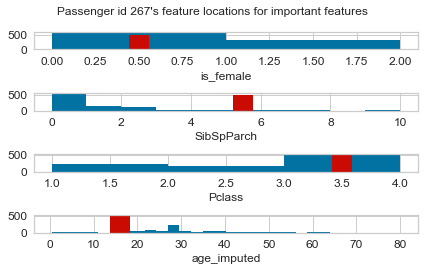

In [47]:
fig, axs = plt.subplots(nrows=4)
bins = {'SibSpParch': 10, 'Pclass': [1, 2, 3, 4], 'Fare': 30, 'is_female': [0, 1, 2], 'age_imputed': 30}
for row_nbr, feature in enumerate(['is_female', 'SibSpParch', 'Pclass', 'age_imputed']):
    ax = axs[row_nbr]
    df_ml[feature].hist(ax=ax, bins=bins[feature])
    ax.set_xlabel(feature)
    x = example[feature]
    if feature in set(['SibSpParch', 'Fare', 'is_female', 'Pclass']):
        x_offset = 0.5
    else:
        x_offset = 0
    ax.vlines(x+x_offset, 0, 500, color='r', linewidth=20)
fig.suptitle("Passenger id {}'s feature locations for important features".format(passenger_id_to_explain))
fig.tight_layout(rect=[0.0, 0.05, 1, 0.93])

### LIME

In [48]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=["died", "lived"], discretize_continuous=True)


In [49]:
exp = explainer.explain_instance(example, clf.predict_proba, num_features=7, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [50]:
exp.as_map()

{0: [(1, 0.4111967580203101),
  (0, 0.13466144460428414),
  (4, -0.12347000969713948),
  (3, -0.06640946294646591),
  (2, 0.04858524814815434)]}

# Learning Curves

* Training score gets worse as data size incrases - it isn't overfitting (it isn't suffering from high bias)
* Test score improves and plateaus - but it is still improving
* High variance (large gap between train & test) - probably we want more data or better features
* Maybe the estimator isn't well-tuned enough? Data set's size could be improved
* http://www.ritchieng.com/machinelearning-learning-curve/

In [51]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


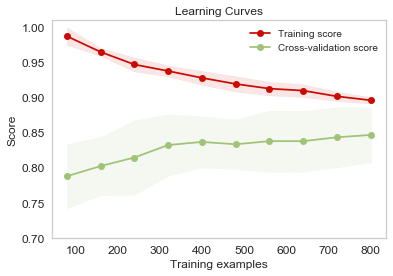

In [52]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
train_sizes = np.linspace(.1, 1.0, 10)
plot_learning_curve(clf, title, X, y, (0.7, 1.01), cv=cv, n_jobs=-1, train_sizes=train_sizes);

# SHAP

"Great! The general idea is to get the total of all the positive SHAP values, and then all the negative SHAP values. You then draw a red and blue bar of each of those lengths ending at the predicted value (with an arrow notch at the start). Then you sort the positive SHAP values by magnitude and draw an inwards facing light red arrow at each junction between the positive SHAP values (note they may overlap at the outside when you get to small SHAP values). Then repeat this for the negative SHAP values. Finally the hard part is determining how many feature labels will fit and then drawing all the polygons and labels and borders in the right places."
https://github.com/slundberg/shap/issues/27

In [53]:
if True:
    # https://github.com/slundberg/shap/blob/master/notebooks/Iris%20classification%20with%20scikit-learn.ipynb
    import shap
    # it is slow to train

    # load JS visualization code to notebook
    shap.initjs() 
    
    # NOTE USING _dbg (.ax_matrix) variants to see if this helps - NO, doesn't help (no .iloc)

    # use Kernel SHAP to explain test set predictions
    print("X_train", X_train.shape)
    explainer = shap.KernelExplainer(clf.predict_proba, X_train)#, link="logit")
    shap_values = explainer.shap_values(X_test)#, nsamples=20) # IAN TRY
    
    #shap_values = np.array(shap_values) # IAN TRY
    
    #shap.force_plot(shap_values[0][0,:], X_test.iloc[0,:])#, link="logit")
    # shap.visualize(shap_values[0], X_test) # same as force_plot
    
    # shap.force_plot(shap_values[0][0], X_test.iloc[0]) # single item, nothing seen?

  0%|          | 0/223 [00:00<?, ?it/s]

X_train (668, 5)


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


In [54]:
shap.force_plot(shap_values[1], X_test)

In [55]:
y_test.iloc[0:5]

PassengerId
496    0
649    0
279    0
32     1
256    1
Name: Survived, dtype: int64

In [56]:
passenger_id_to_explain = 635
# use eli5 index to check into our X_test array
idx_to_debug = (X_test.index == passenger_id_to_explain).argmax()
print("Passenger id", passenger_id_to_explain, "Truth:", y_test.iloc[idx_to_debug])
print(clf.predict_proba([X_test.iloc[idx_to_debug]]))
X_test.iloc[idx_to_debug]

Passenger id 635 Truth: 0
[[0.97023499 0.02976501]]


Pclass          3.0
is_female       1.0
SibSpParch      5.0
Fare           27.9
age_imputed     9.0
Name: 635, dtype: float64

In [57]:
shap.force_plot(shap_values[1][idx_to_debug], X_test.iloc[idx_to_debug]) 

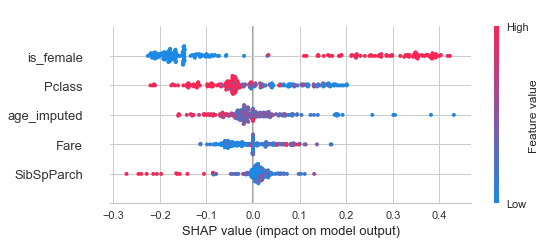

In [58]:
# https://github.com/slundberg/shap/blob/master/notebooks/Census%20income%20classification%20with%20scikit-learn.ipynb
shap.summary_plot(shap_values[1], X_test)

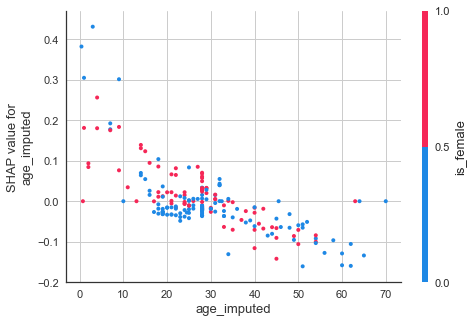

In [59]:
shap.dependence_plot("age_imputed", shap_values[1], X_test)

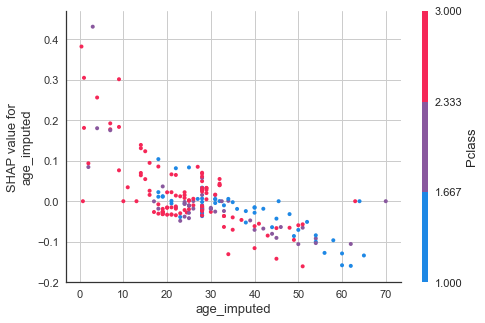

In [60]:
shap.dependence_plot("age_imputed", shap_values[1], X_test, interaction_index="Pclass")

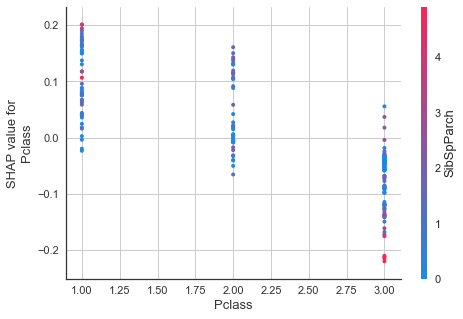

In [61]:
shap.dependence_plot("Pclass", shap_values[1], X_test, interaction_index="SibSpParch")

# TSNE

Use T-SNE to group similar examples (by features, not by target) onto a 2D plane. Set their symbol to be survived/died. Set their colour to be "size of error". Do a visual diagnostic for whether the errors seem to be grouped around areas of similar features.

In [62]:
# Note even with random_state we cannot get repeatable results
# The structure is similar, groupings are similar, placement changes
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=100, random_state=0)
X_test_embedded = TSNE(n_components=2).fit_transform(X_test)

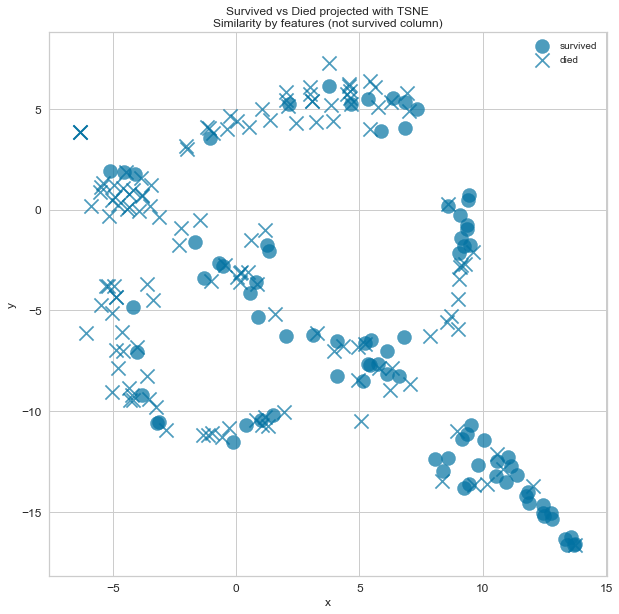

In [63]:
df_X_test_embedded = pd.DataFrame(X_test_embedded, columns=['x', 'y'])
df_X_test_embedded['survived'] = y_test.values
df_X_test_embedded['abs_error'] = test_features_prediction.abs_error.values
df_X_test_embedded['test_features_prediction_index'] = test_features_prediction.index

# colour by abs_error or survived
#df_X_test_embedded.plot(kind="scatter", x="x", y="y", c='survived', cmap='hot');

fig, ax = plt.subplots(figsize=(10, 10))
alpha = 0.7
MARKER_MULTIPLIER = 200
df_X_test_embedded_scatter = df_X_test_embedded.query("survived==True")
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                marker="o", s=MARKER_MULTIPLIER,
                                ax=ax, alpha=alpha, label="survived");
df_X_test_embedded_scatter = df_X_test_embedded.query("survived==False")
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                 marker="x", s=MARKER_MULTIPLIER,
                                label="died", alpha=alpha, ax=ax,);

ax.legend()
ax.set_title("Survived vs Died projected with TSNE\nSimilarity by features (not survived column)");

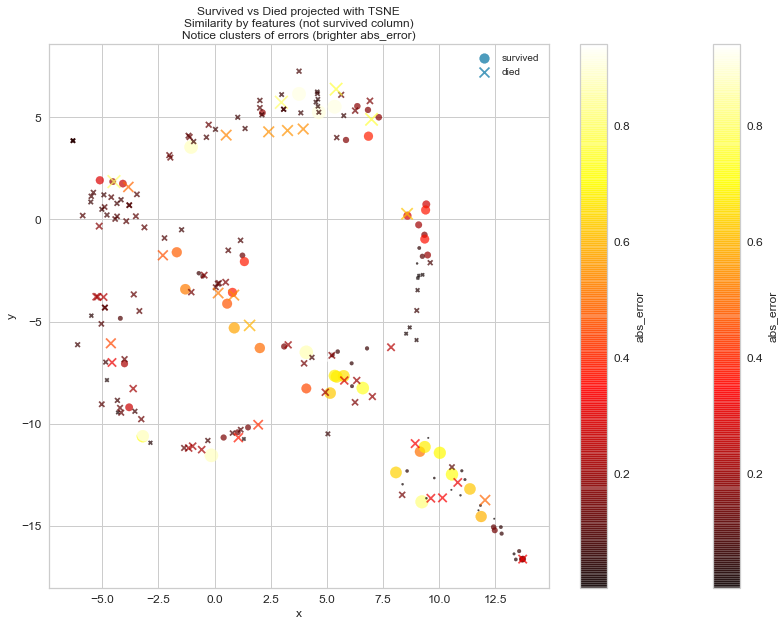

In [64]:
# note we could 'zoom in'
#subset_of_imputed_ages_query = "-x > 5 and -y > 10"
#df_X_test_embedded_subset = df_X_test_embedded.query(subset_of_imputed_ages_query)

# colour by abs_error or survived
markers = np.where(df_X_test_embedded.survived, "o", "x")

fig, ax = plt.subplots(figsize=(14, 10))
alpha = 0.7
MARKER_MULTIPLIER = 200
df_X_test_embedded_scatter = df_X_test_embedded.query("survived==True")
marker_size = (df_X_test_embedded_scatter.abs_error + 0.01) * MARKER_MULTIPLIER
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                c='abs_error', marker="o", s=marker_size,
                                                cmap='hot', ax=ax, alpha=alpha, label="survived");
df_X_test_embedded_scatter = df_X_test_embedded.query("survived==False")
marker_size = (df_X_test_embedded_scatter.abs_error + 0.01) * MARKER_MULTIPLIER
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                 c='abs_error', marker="x", s=marker_size,
                                                 cmap='hot', ax=ax, alpha=alpha, label="died");
ax.legend()
ax.set_title("Survived vs Died projected with TSNE\nSimilarity by features (not survived column)\nNotice clusters of errors (brighter abs_error)");

In [65]:
df.loc[265]

Survived                        0
Pclass                          3
Name           Henry, Miss. Delia
Sex                        female
Age                           NaN
SibSp                           0
Parch                           0
Ticket                     382649
Fare                         7.75
Cabin                         NaN
Embarked                        Q
SibSpParch                      0
is_female                       1
age_imputed                    28
Name: 265, dtype: object

### Reviewing ages against truth

* https://www.encyclopedia-titanica.org/titanic-passenger-list/

* Willey, Mr. Edward (passenger 649), imputed 28, actual 21, correct (died)
* Moussa, Mrs. (Mantoura Boulos) (368), imputed 28, actual 35, correct (survived)
* Henry, Miss. Delia (265), imputed 28, actual 22, error (predicted survived, she died)

In [66]:
# note that this query depends on the non-deterministic TSNE run
# see the presentations (linked at the top of this Notebook) for a clear example
#query = "x > 0 and y > 0"
#query = "x < -4 and y < 1"
query = "-x > 4 and y < 1" # odd group of similar age_imputed

pd.concat((X_test.loc[df_X_test_embedded.query(query).test_features_prediction_index], \
    df_X_test_embedded.query(query).set_index('test_features_prediction_index')), axis=1) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,Pclass,is_female,SibSpParch,Fare,age_imputed,x,y,survived,abs_error
347,2,1,0,13,40,-4.01063,-7.05739,1,0.227141
615,3,0,0,8.05,35,-5.04213,-5.10944,0,0.122323
779,3,0,0,7.7375,28,-5.01926,0.493636,0,0.0964866
520,3,0,0,7.8958,32,-5.20591,-3.78423,0,0.229102
286,3,0,0,8.6625,33,-4.88178,-4.31398,0,0.134232
478,3,0,1,7.0458,29,-5.87322,0.1858,0,0.122887
819,3,0,0,6.45,43,-4.79255,-7.85963,0,0.0537705
102,3,0,0,7.8958,28,-4.79186,0.216031,0,0.103354
657,3,0,0,7.8958,28,-4.34705,0.782062,0,0.103354
809,2,0,0,13,39,-4.00857,-6.83737,0,0.156546


In [67]:
# note that this query all depends on the non-deterministic run from TSNE (which is a pain) 
# see the presentations (linked at the top of this Notebook) for a clear example
query = "x > 2 and x < 6 and y > 6 and y < 9"

pd.concat((X_test.loc[df_X_test_embedded.query(query).test_features_prediction_index], \
    df_X_test_embedded.query(query).set_index('test_features_prediction_index')), axis=1) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,Pclass,is_female,SibSpParch,Fare,age_imputed,x,y,survived,abs_error
716,3,0,0,7.65,19,4.57753,6.24116,0,0.0731617
176,3,0,2,7.8542,18,5.64441,6.09229,0,0.147905
655,3,1,0,6.75,18,5.41783,6.37044,0,0.764107
763,3,0,0,7.2292,20,3.76483,6.13879,1,0.911337
379,3,0,0,4.0125,20,3.76639,7.24971,0,0.105065
492,3,0,0,7.25,21,2.99028,6.10625,0,0.0842828
380,3,0,0,7.775,19,4.58736,6.14958,0,0.0888053


# End of Notebook

In [68]:
print("Finished:", datetime.datetime.now())

Finished: 2018-05-27 14:59:36.331677
